### andなどの複数出現する単語は必ずくっつける
バッチサイズ分だけ並行して実施する

In [1]:
ex_num = "012"

In [2]:
import os
# 環境によって変更
os.chdir('/home/jovyan/work/notebook')

In [3]:
class CFG:
    path = "../model"    
    # path = "../../output"
    base_file_path = "../input/sub20241221.csv"
    
    # 焼きなましのパラメータ
    temperature=100
    end_temperature=0.01
    cooling_rate=0.9999
    iteration=int(1e2)
    batch_size=4
    interval=10
    neighbor_types = ["swap", "insert", "segment_insert"]

In [4]:
import numpy as np
import pandas as pd
import os
import time
import csv

from tqdm.notebook import tqdm

import random
from typing import List, Callable
import itertools, math
from typing import List, Tuple

from utils import PerplexityCalculator
# 可視化用
import matplotlib.pyplot as plt

### データ読み込み

In [5]:
df = pd.read_csv(CFG.base_file_path)

In [6]:
sub_df = df.copy()
sub_df["best_value"] = 0

In [7]:
df

,id,text
0,0,reindeer mistletoe elf gingerbread family adve...
1,1,reindeer sleep walk the night and drive mistle...
2,2,jingle yuletide carol cheer holly stocking chi...
3,3,sleigh the holly jingle unwrap gifts of magi r...
4,4,peppermint candy milk chocolate eggnog fruitca...
5,5,poinsettia yuletide eggnog fruitcake gingerbre...


### 関数

In [8]:
def split_compress(sentence: str) -> list[str]:
    words = sentence.split()
    if not words:
        return []

    result = []
    prev_word = None

    for w in words:
        if w == prev_word:
            # 連続している場合は、リストの最後の要素にスペースを挟んで追加
            result[-1] += " " + w
        else:
            # 新しい単語の場合はリストに追加
            result.append(w)
        prev_word = w

    return result

In [9]:
def plot_score_and_temperature(scores_history, temp_history):
    # x 軸: イテレーション
    x = range(len(scores_history))
    
    # Figure と Axes を作成
    fig, ax1 = plt.subplots(figsize=(8,5))
    
    # スコア用の軸 (左)
    color_score = 'tab:blue'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Score (Perplexity)', color=color_score)
    ax1.plot(x, scores_history, label='Score', color=color_score)
    ax1.tick_params(axis='y', labelcolor=color_score)
    
    # 温度用の軸 (右) : twinx で第二のY軸を作成
    ax2 = ax1.twinx()
    color_temp = 'tab:red'
    ax2.set_ylabel('Temperature', color=color_temp)
    ax2.plot(x, temp_history, label='Temperature', color=color_temp)
    ax2.tick_params(axis='y', labelcolor=color_temp)
    
    # タイトル等
    plt.title('Score & Temperature Transition')
    fig.tight_layout()
    plt.show()

In [10]:
# 文字の順番をランダムにして、返す
def shuffle_initialize(
    scorer,
    words
):
    random.shuffle(words)
    return words, scorer.get_perplexity([" ".join(words)], batch_size=1)[0]

In [11]:
def generate_neighbor(sequence, neighbor_type='swap'):
    """
    sequence: list of words
    neighbor_type: str, 近傍生成の種類 ('swap', 'insert', etc.)
    """
    new_seq = sequence[:]
    length = len(new_seq)

    if neighbor_type == 'swap':
        # ランダムに2つの位置を選んで入れ替える
        a, b = random.sample(range(length), 2)
        new_seq[a], new_seq[b] = new_seq[b], new_seq[a]

    elif neighbor_type == 'insert':
        # ある単語を抜き出し、別の位置に挿入する
        idx = random.randint(0, length - 1)
        word = new_seq.pop(idx)
        new_pos = random.randint(0, length - 1)
        new_seq.insert(new_pos, word)

    elif neighbor_type == 'segment_insert':
        # 長さ2~5のランダムな部分区間を切り出して、別の位置に挿入
        # 部分区間の長さをランダムに選択（2～5）
        sublist_length = random.randint(2, 5)

        # 部分区間の開始位置をランダムに選択
        start_idx = random.randint(0, length - sublist_length)

        # 部分区間を切り出し
        sublist = new_seq[start_idx:start_idx + sublist_length]

        # 部分区間を元のリストから削除
        new_seq = new_seq[:start_idx] +new_seq[start_idx + sublist_length:]

        # 挿入位置をランダムに選択（元の部分区間の位置は除く）
        insert_idx = random.randint(0, len(new_seq))

        # 切り出した部分区間を挿入
        new_seq = new_seq[:insert_idx] + sublist + new_seq[insert_idx:]

    # 他にも様々な近傍操作を追加可能

    return new_seq

In [12]:
def search_annealing(
    scorer,
    initial_sequence,
    temperature: float = 1.0,
    end_temperature: float = 0.01,
    cooling_rate: float = 0.999,
    iteration: int = 1000,
    batch_size: int = 10,
    interval: int = 1000,
    neighbor_types: list = None
):
    """
    焼きなまし法による探索

    Parameters
    ----------
    CFG: 設定用（必要に応じて）
    scorer: perplexityを計算できるオブジェクト
    initial_sequence: 初期の単語リスト
    temperature: 開始時の温度
    cooling_rate: 温度の減少率
    iteration: 探索の反復回数
    batch_size: 1ステップで生成する近傍候補の数
    neighbor_types: 近傍生成の種類を指定するリスト
    """
    if neighbor_types is None:
        neighbor_types = ['swap', 'insert', 'shuffle_segment', 'reverse_segment']
    print("neighbor_types:", neighbor_types)
    
    # 初期状態
    current_seq = initial_sequence[:]
    best_seq = current_seq[:]
    best_score = scorer.get_perplexity([" ".join(current_seq)], batch_size=1)[0]

    # current_scoreの計算
    current_score = best_score

    # スコア推移を記録するリスト
    scores_history = []
    temp_history = []
    
    # 現在の状態を持つリスト
    current_seqs = []
    current_scores = []
    
    # 初期解の生成
    for _ in range(CFG.batch_size):
        print("current_seq:", current_seq)
        print("current_score:", current_score)
        current_seq, current_score = shuffle_initialize(
            scorer,
            current_seq,
        )
        current_seqs.append(current_seq)
        current_scores.append(current_score)
        
    for itr in tqdm(range(iteration)):
        # 記録（ループの冒頭 or 最後のどちらでもOK）
        scores_history.append(current_scores[0])
        temp_history.append(temperature)
        
        # 近傍候補をまとめて生成
        neighbor_candidates = []
        for i in range(CFG.batch_size):
            # 近傍操作の種類をランダムに選ぶ
            n_type = random.choice(neighbor_types)
            neighbor_seq = generate_neighbor(current_seqs[i], n_type)
            neighbor_candidates.append(neighbor_seq)

        
        # まとめてスコアを計算（GPUを活用）
        texts = [" ".join(seq) for seq in neighbor_candidates]
        # print("texts:", texts)
        
        scores = scorer.get_perplexity(texts, batch_size=batch_size)
        # print("scores:", scores)
        
        # 候補の中から1つを焼きなまし法の確率的受容ルールで選ぶ
        for i, (cand_seq, cand_score) in enumerate(zip(neighbor_candidates, scores)):
            delta = cand_score - current_scores[i]
            accept_prob = math.exp(-delta / temperature) if delta > 0 else 1.0
                
            # スコアが良ければ必ず受容
            if (itr==0) or (random.random() < accept_prob):
                current_scores[i] = cand_score
                current_seqs[i] = cand_seq

        # ベストの更新
        # currnet_scoresのリストの最小値を取得
        if np.min(current_scores) < best_score:
            # current_scoresの最小値のインデックスを取得
            idx = np.argmin(current_scores)
            
            best_score = current_scores[idx]
            best_seq = current_seqs[idx]
            print(f"iter {itr}: best_score: {best_score}")
            print("best_seq:", best_seq)

        # 温度を下げる
        if itr % 10 == 0:
            temperature *= cooling_rate
        
        if itr % interval == 0:
            print(f"iter :{itr}, best_score: {best_score}, temperature: {temperature}")

            # current_seqsを結合して文字列保存
            current_seqs_text = [" ".join(seq) for seq in current_seqs]
            # current_seqsとcurrent_scoresのリストをdfとして保存
            df = pd.DataFrame(current_seqs_text)
            df["score"] = current_scores
            
            # indexとなっていたものをsequencre列に変更
            df = df.reset_index()
            df = df.rename(columns={"index": "sequence"})
            
            df.to_csv(f"{CFG.path}/out/current_texts_{ex_num}.csv", index=False)
        if temperature < end_temperature:
            break
        
    return best_seq, best_score, scores_history, temp_history

In [13]:
def search_optimal_permutation(
    CFG,
    id: int, 
    scorer
):
    
    df = pd.read_csv(CFG.base_file_path)
    
    
    start = time.time()
    # 文字列を単語に分割
    text = df.loc[id,"text"]
    words = split_compress(text)
    # wordsをソート
    words.sort()
    text = " ".join(words)
    words = split_compress(text)
    
    initial_sequence = words[:]
    print("--------初期配置の組み合わせ計算開始---------")
    initial_sequence, initial_score = shuffle_initialize(
        scorer=scorer,
        words=words
    )
    
    print(f"{id}th sample: {initial_sequence}")
    print(f"Elapsed time: {time.time() - start:.2f} sec")
    print(f"initial_score: {initial_score}")
    print("--------初期配置の組み合わせ計算終了---------")
    
    print("---------焼きなまし処理開始---------")
    best_sequence, best_score, scores_history, temp_history = search_annealing(
        scorer=scorer,
        initial_sequence=initial_sequence,
        temperature=CFG.temperature,
        end_temperature=CFG.end_temperature,
        cooling_rate=CFG.cooling_rate,
        iteration=CFG.iteration,
        batch_size=CFG.batch_size,
        interval=CFG.interval,
        neighbor_types=CFG.neighbor_types
    )
    print("---------焼きなまし処理終了---------")
    
    print(f"{id}th sample: {best_sequence}")
    print(f"Elapsed time: {time.time() - start:.2f} sec")
    print(f"best_score: {best_score}")
    
    plot_score_and_temperature(scores_history, temp_history)
    
    return best_sequence, best_score


In [14]:
# 文字列型にのみダブルクォーテーションを付ける関数
def add_quotes_to_strings(value):
    if isinstance(value, str):  # 文字列型の場合
        return f'"{value}"'
    return value  # それ以外はそのまま

In [15]:
# LOAD GEMMA SCORER
scorer = PerplexityCalculator(f'{CFG.path}/gemma_2_9b')

cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [16]:
# scorer.clear_gpu_memory()

Processing 5th sample
--------初期配置の組み合わせ計算開始---------
5th sample: ['fruitcake', 'give', 'cheer cheer', 'carol', 'dream', 'relax', 'drive', 'not', 'peace', 'hope', 'scrooge', 'family', 'kaggle', 'unwrap', 'with', 'laugh', 'doll', 'chimney chimney', 'angel', 'visit', 'bake', 'have', 'magi', 'star', 'wreath', 'elf', 'believe', 'to', 'grinch', 'jump', 'candle', 'naughty', 'night night', 'sleigh', 'advent', 'milk', 'chocolate', 'eggnog', 'it', 'sing', 'reindeer', 'toy', 'we', 'holiday', 'from', 'stocking', 'wish', 'jingle', 'season', 'ornament ornament', 'in', 'polar', 'paper', 'and and and', 'snowglobe', 'candy', 'eat', 'mistletoe', 'decorations', 'game', 'the the the', 'nutcracker', 'puzzle', 'poinsettia', 'hohoho', 'is', 'peppermint', 'holly', 'as', 'sleep', 'greeting', 'that', 'you', 'card', 'nice', 'yuletide', 'cookie', 'gifts', 'wrapping', 'walk', 'merry', 'of of', 'fireplace fireplace', 'bow', 'workshop workshop', 'wonder', 'gingerbread', 'joy', 'beard']
Elapsed time: 1.06 sec
initia

  0%|          | 0/100 [00:00<?, ?it/s]

iter :0, best_score: 762.5886393094895, temperature: 99.99
iter :10, best_score: 762.5886393094895, temperature: 99.980001
iter 14: best_score: 742.0191118159325
best_seq: ['toy', 'wish', 'believe', 'holiday', 'magi', 'of of', 'dream', 'polar', 'is', 'yuletide', 'that', 'candle', 'reindeer', 'bake', 'puzzle', 'sleigh', 'night night', 'sleep', 'jump', 'beard', 'elf', 'bow', 'peace', 'hope', 'candy', 'cheer cheer', 'have', 'drive', 'greeting', 'walk', 'card', 'it', 'cookie', 'jingle', 'workshop workshop', 'kaggle', 'grinch', 'with', 'eat', 'carol', 'holly', 'paper', 'from', 'we', 'advent', 'star', 'eggnog', 'fireplace fireplace', 'game', 'family', 'angel', 'gifts', 'wreath', 'doll', 'stocking', 'joy', 'the the the', 'naughty', 'you', 'ornament ornament', 'gingerbread', 'as', 'in', 'wrapping', 'mistletoe', 'scrooge', 'merry', 'visit', 'and and and', 'hohoho', 'poinsettia', 'give', 'laugh', 'season', 'snowglobe', 'chocolate', 'to', 'sing', 'chimney chimney', 'not', 'unwrap', 'peppermint', 

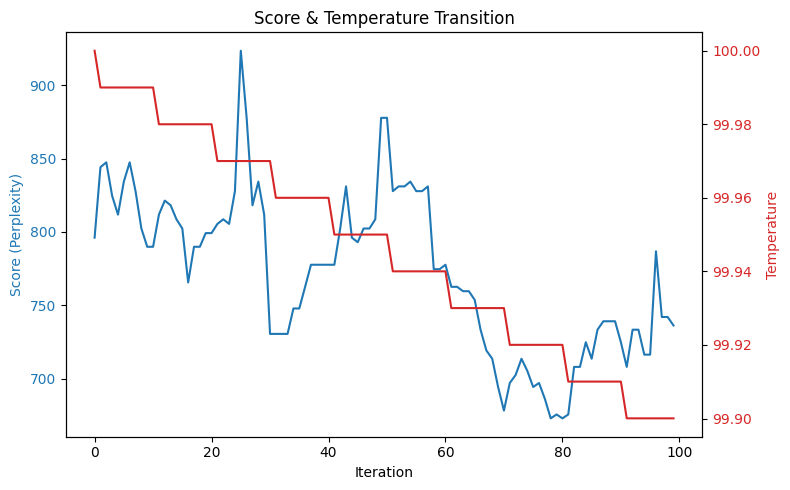

Best sequence: ['toy', 'wish', 'believe', 'grinch', 'holiday', 'magi', 'yuletide', 'it', 'the the the', 'of of', 'polar', 'is', 'advent', 'nutcracker', 'chimney chimney', 'not', 'paper', 'card', 'game', 'workshop workshop', 'puzzle', 'visit', 'walk', 'kaggle', 'reindeer', 'with', 'joy', 'ornament ornament', 'candle', 'nice', 'naughty', 'merry', 'chocolate', 'give', 'laugh', 'poinsettia', 'eggnog', 'that', 'we', 'cookie', 'jingle', 'bake', 'to', 'sing', 'peace', 'hope', 'from', 'hohoho', 'star', 'unwrap', 'fireplace fireplace', 'wreath', 'family', 'angel', 'jump', 'stocking', 'sleep', 'you', 'gingerbread', 'as', 'dream', 'wrapping', 'mistletoe', 'scrooge', 'beard', 'wonder', 'milk', 'drive', 'decorations', 'fruitcake', 'elf', 'bow', 'gifts', 'cheer cheer', 'have', 'doll', 'greeting', 'sleigh', 'night night', 'season', 'relax', 'eat', 'candy', 'and and and', 'carol', 'holly', 'snowglobe', 'peppermint', 'in']
Best score: 600.905389292032


/tmp/ipykernel_37/1733285752.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '600.905389292032' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sub_df.loc[i, "best_value"] = best_score


In [17]:
for i in [5]:
    
    print(f"Processing {i}th sample")
    best_sequence, best_score = search_optimal_permutation(
        CFG,
        id=i,
        scorer=scorer,
    )
    
    print("Best sequence:", best_sequence)
    print("Best score:", best_score)
    sub_df.loc[i, "best_value"] = best_score
    sub_df.loc[i, "text"] = " ".join(best_sequence)



In [18]:
sub_df

,id,text,best_value
0,0,reindeer mistletoe elf gingerbread family adve...,0.000000
1,1,reindeer sleep walk the night and drive mistle...,0.000000
2,2,jingle yuletide carol cheer holly stocking chi...,0.000000
3,3,sleigh the holly jingle unwrap gifts of magi r...,0.000000
4,4,peppermint candy milk chocolate eggnog fruitca...,0.000000
5,5,toy wish believe grinch holiday magi yuletide ...,600.905389


In [19]:
# 各セルに関数を適用
sub_df["text"] = sub_df["text"].astype(str)
sub_df = sub_df.applymap(add_quotes_to_strings)

/tmp/ipykernel_37/428122046.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sub_df = sub_df.applymap(add_quotes_to_strings)


In [20]:
sub_df[["id", "text"]].to_csv(f"{CFG.path}/out/submission_{ex_num}.csv", index=False, header=True, quoting=csv.QUOTE_NONE)
sub_df.to_csv(f"{CFG.path}/out/score_{ex_num}.csv", index=False, header=True, quoting=csv.QUOTE_NONE)

In [21]:
np.mean(sub_df["best_value"])

np.float64(100.15089821533867)